Loading datasets...
BoT-IoT shape: (1150356, 16), ToN-IoT shape: (484750, 16)
BoT DDoS ratio: 0.997
ToN DDoS ratio: 0.562
Selected 8 features from source dataset:
  1. Total Backward Packets (importance: 0.0810)
  2. Total Fwd Packets (importance: 0.0968)
  3. Flow Duration (importance: 0.0982)
  4. Flow Packets/s (importance: 0.1045)
  5. Bwd IAT Mean (importance: 0.1118)
  6. Fwd IAT Mean (importance: 0.1128)
  7. Flow Bytes/s (importance: 0.1196)
  8. Flow IAT Mean (importance: 0.1198)

=== Chi-Square Feature Importance ===
               Feature  Chi_square_score  p_value
          Fwd IAT Mean      1.966645e+10      0.0
          Flow Bytes/s      1.002091e+10      0.0
          Bwd IAT Mean      9.832886e+09      0.0
        Flow Packets/s      9.818978e+08      0.0
         Flow IAT Mean      2.779386e+08      0.0
         Flow Duration      1.244292e+08      0.0
     Total Fwd Packets      9.703801e+07      0.0
Total Backward Packets      4.770278e+07      0.0
Starting comprehe

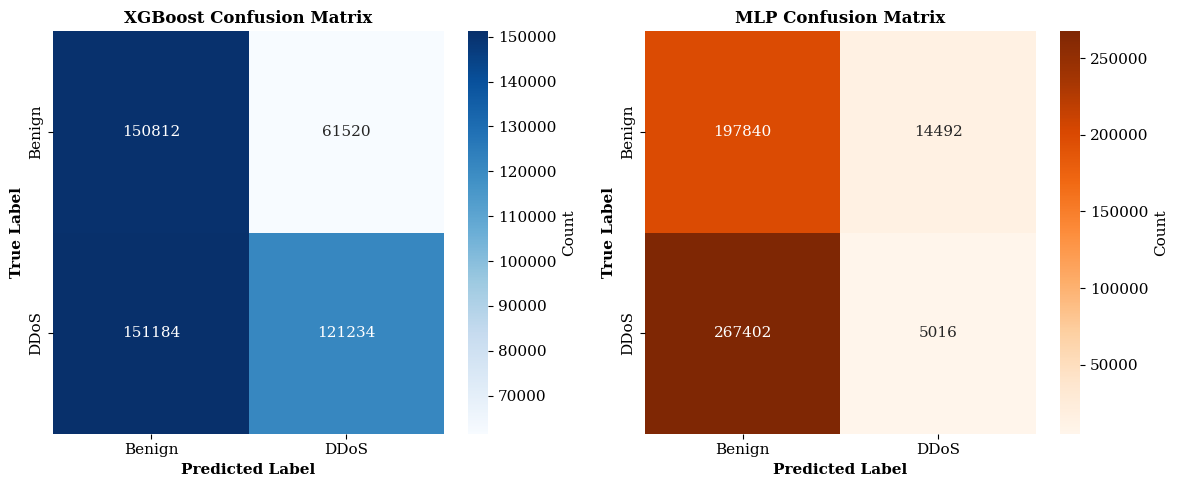

Figure 1 saved: figure1_confusion_matrices.png
Generating Figure 2: ROC Curves...


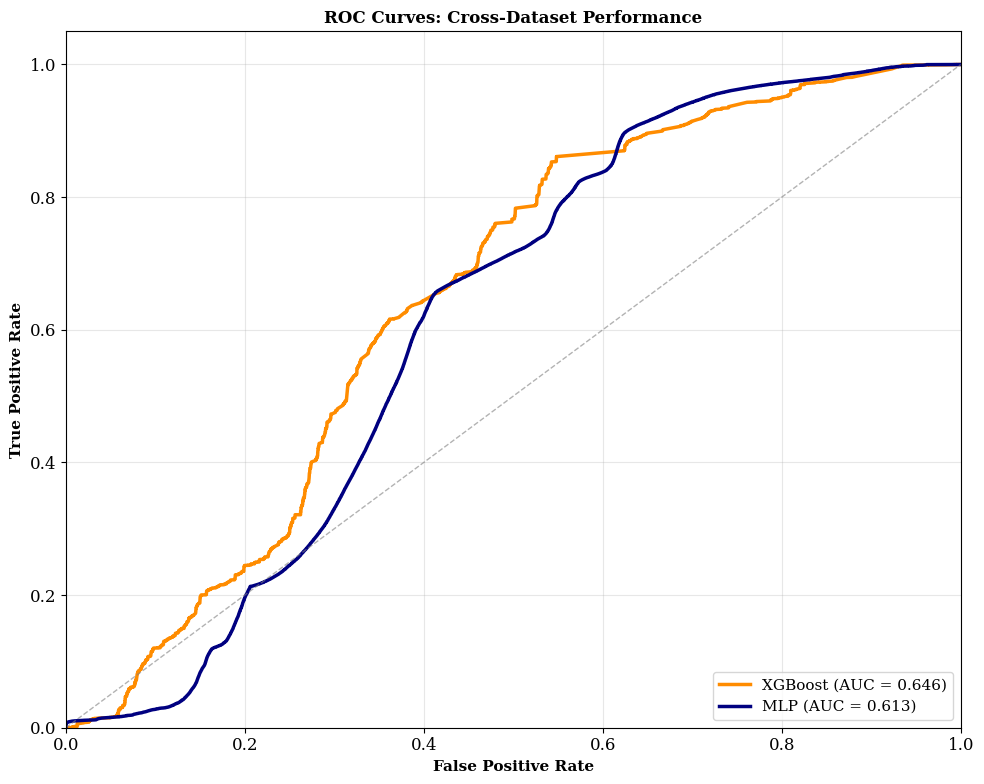

Figure 2 saved: figure2_roc_curves.png
Generating Figure 3: Metrics Comparison Bar Chart...


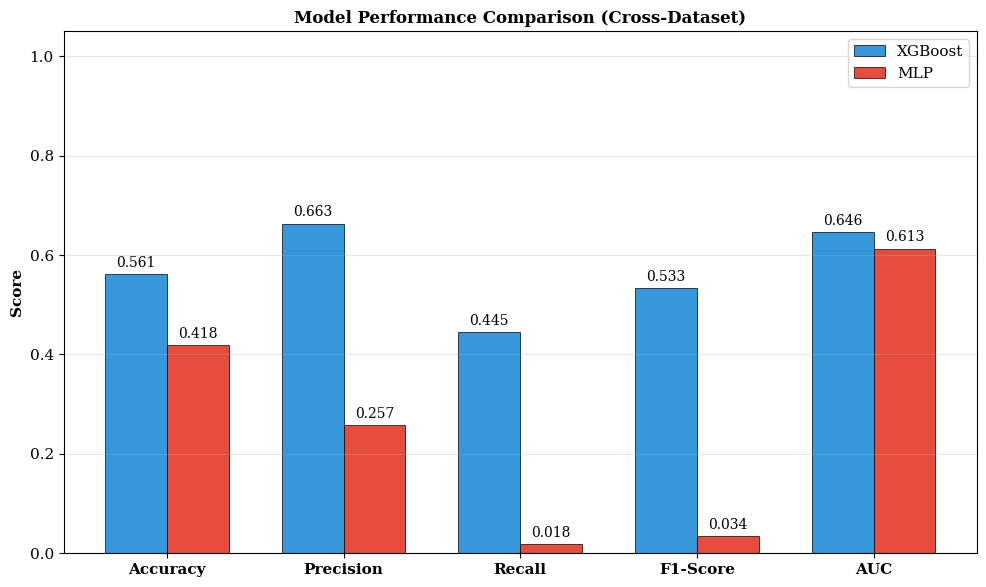

Figure 3 saved: figure3_metrics_comparison.png
Generating Figure 4: Cross-Validation Metric Distribution...


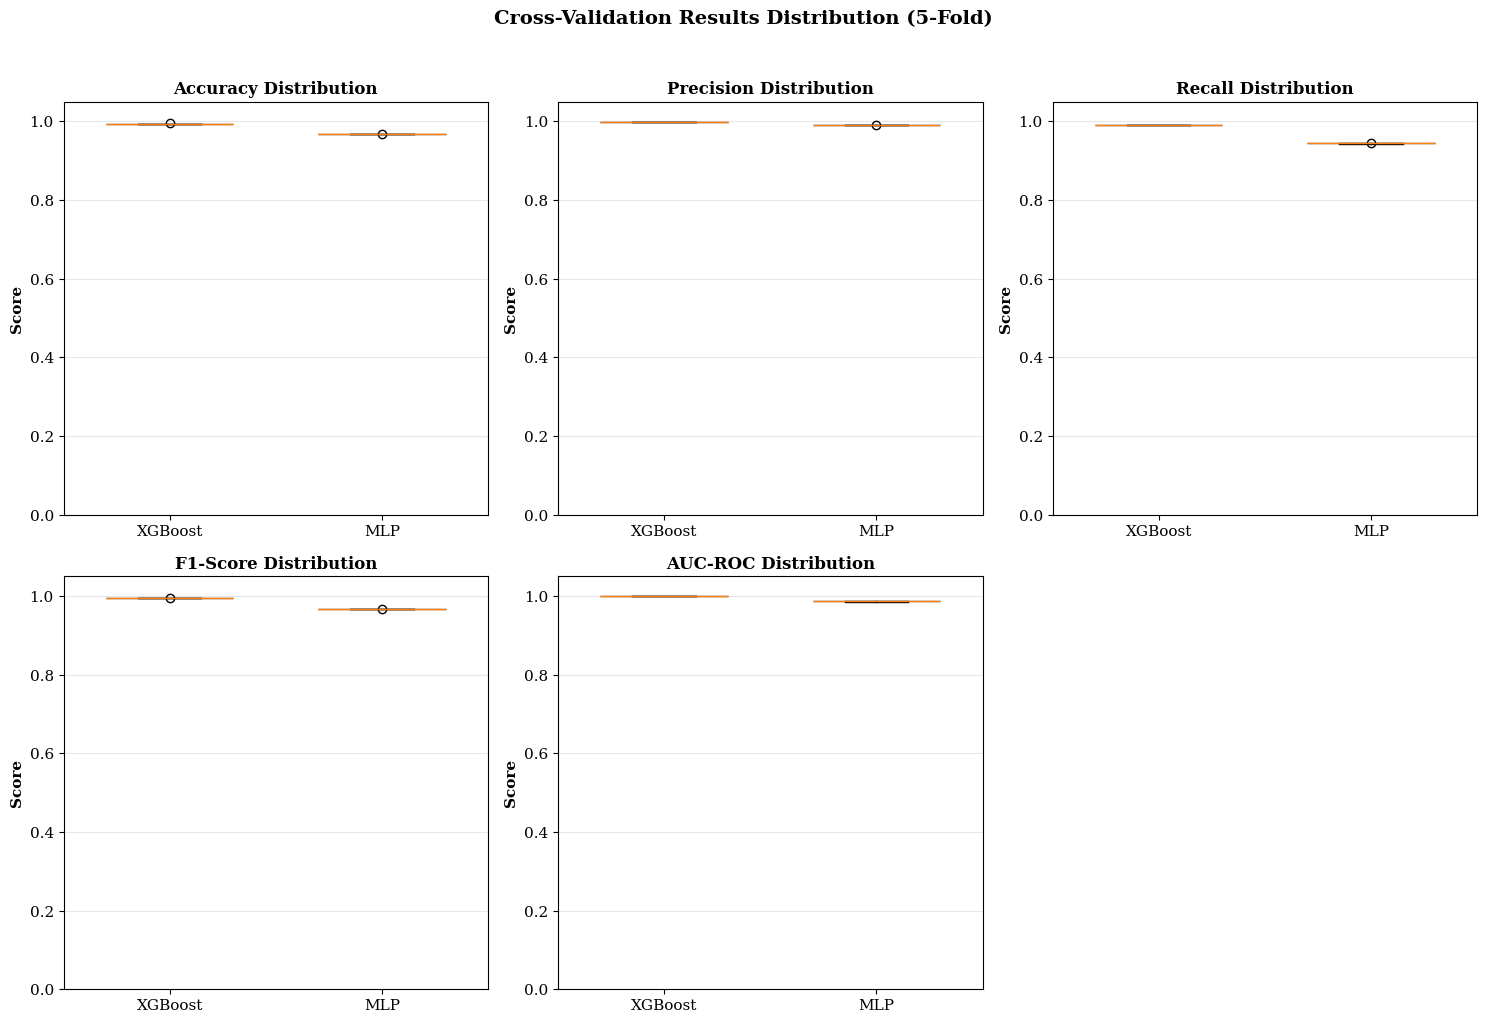

Figure 4 saved: figure4_cv_distribution.png

FINAL RESULTS SUMMARY

Cross-Dataset Performance Summary (BoT → ToN):
   Metric  XGBoost      MLP  Improvement
 Accuracy 0.561209 0.418476    -0.142733
Precision 0.663373 0.257125    -0.406247
   Recall 0.445029 0.018413    -0.426616
 F1-Score 0.532695 0.034365    -0.498330
      AUC 0.645943 0.613023    -0.032920

Average improvement of MLP over XGBoost: -0.3014

KEY INSIGHTS
✓ XGBoost achieves better overall performance (F1-Score)
✓ XGBoost shows better discrimination ability (AUC)

Generalization Gap (CV F1 - Cross-dataset F1):
  XGBoost: 0.4621
  MLP:     0.9330
✓ XGBoost generalizes better across datasets

EXPERIMENT COMPLETED SUCCESSFULLY!

Files generated for publication:
  Tables: table1_performance_metrics.txt, table2_cv_summary.txt,
          table3_scaling_description.txt, table4_chi_square_features.txt
  Figures: figure1_confusion_matrices.png, figure2_roc_curves.png,
           figure3_metrics_comparison.png, figure4_cv_distribu

In [1]:
# ============================
# COMPREHENSIVE MODEL COMPARISON: XGBoost vs MLP for IoT DDoS Detection
# ============================
# Install required packages
!pip install -q xgboost scikit-learn imbalanced-learn scipy seaborn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Deep Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# XGBoost
import xgboost as xgb

# Statistical testing
from scipy.stats import ttest_rel, wilcoxon

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ============================
# 1. DATA LOADING AND PREPROCESSING
# ============================
def load_data(sample_fraction=0.1):
    """Load and preprocess both datasets"""
    print("Loading datasets...")
    
    # Load datasets
    BOT_PATH = "/kaggle/input/cicbotiot/CIC-BoT-IoT-V2.parquet"
    TON_PATH = "/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet"
    
    # Feature sets (common to both)
    COMMON_FEATURES = [
        'Flow Duration',
        'Total Fwd Packets',
        'Total Backward Packets',
        'Fwd Packet Length Max',
        'Bwd Packet Length Max',
        'Flow Bytes/s',
        'Flow Packets/s',
        'Flow IAT Mean',
        'Fwd IAT Mean',
        'Bwd IAT Mean',
        'Fwd PSH Flags',
        'Bwd PSH Flags',
        'FIN Flag Count',
        'SYN Flag Count',
        'ACK Flag Count'
    ]
    
    # Load with sampling
    bot = pd.read_parquet(BOT_PATH, columns=COMMON_FEATURES + ['Label'])
    bot = bot.sample(frac=sample_fraction, random_state=SEED)
    
    ton = pd.read_parquet(TON_PATH, columns=COMMON_FEATURES + ['Label'])
    ton = ton.sample(frac=sample_fraction, random_state=SEED)
    
    # Print dataset info
    print(f"BoT-IoT shape: {bot.shape}, ToN-IoT shape: {ton.shape}")
    print(f"BoT DDoS ratio: {bot['Label'].mean():.3f}")
    print(f"ToN DDoS ratio: {ton['Label'].mean():.3f}")
    
    return bot, ton, COMMON_FEATURES

# Load data
bot_data, ton_data, COMMON_FEATURES = load_data(sample_fraction=0.1)

# ============================
# 2. SOURCE-ONLY FEATURE SELECTION (FIXED: No target data leakage)
# ============================
def source_only_feature_selection(X_source, feature_names, target_ratio=0.3, min_features=5):
    """
    Feature selection using ONLY source data (no target leakage)
    1. Remove near-constant features
    2. Select by XGBoost importance
    3. Return selected features and importance scores
    """
    # Step 1: Remove near-constant features
    var_selector = VarianceThreshold(threshold=0.01)
    X_var = var_selector.fit_transform(X_source)
    var_features = [feature_names[i] for i in var_selector.get_support(indices=True)]
    
    # Step 2: Quick XGBoost to get importance
    from xgboost import XGBClassifier
    xgb_temp = XGBClassifier(n_estimators=50, random_state=SEED, verbosity=0)
    
    # Create temporary balanced sample for importance calculation
    y_temp = np.zeros(len(X_var))
    y_temp[:min(10000, len(X_var))] = 1  # Balanced dummy labels
    
    xgb_temp.fit(X_var[:len(y_temp)], y_temp)  # Use only first 10k samples
    importances = xgb_temp.feature_importances_
    
    # Step 3: Select top features
    n_select = max(min_features, int(len(var_features) * target_ratio))
    top_idx = np.argsort(importances)[-n_select:]
    selected = [var_features[i] for i in top_idx]
    
    print(f"Selected {len(selected)} features from source dataset:")
    for i, feat in enumerate(selected, 1):
        print(f"  {i}. {feat} (importance: {importances[var_features.index(feat)]:.4f})")
    
    return selected, importances

# Prepare source data
X_bot_all = bot_data[COMMON_FEATURES].values
y_bot_all = bot_data['Label'].values

X_ton_all = ton_data[COMMON_FEATURES].values
y_ton_all = ton_data['Label'].values

# Apply source-only feature selection
selected_features, feature_importances = source_only_feature_selection(
    X_bot_all, COMMON_FEATURES, target_ratio=0.5, min_features=8
)

# Filter datasets
X_bot = bot_data[selected_features].values
X_ton = ton_data[selected_features].values

# ============================
# 3. FEATURE SCALING (STANDARDIZATION)
# ============================
def apply_scaling(X_train, X_test):
    """Apply standard scaling"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

# ============================
# 4. CHI-SQUARE FEATURE IMPORTANCE (OPTIONAL)
# ============================
def calculate_chi_square_features(X, y, feature_names):
    """Calculate Chi-square statistics for features"""
    if len(np.unique(y)) > 2:
        print("Warning: Chi-square requires binary labels. Using ANOVA F-value instead.")
        from sklearn.feature_selection import f_classif
        f_scores, p_values = f_classif(X, y)
        
        chi_results = pd.DataFrame({
            'Feature': feature_names,
            'Score': f_scores,
            'p_value': p_values
        })
        chi_results = chi_results.sort_values('Score', ascending=False)
    else:
        from sklearn.feature_selection import chi2
        chi_scores, p_values = chi2(X, y)
        
        chi_results = pd.DataFrame({
            'Feature': feature_names,
            'Chi_square_score': chi_scores,
            'p_value': p_values
        })
        chi_results = chi_results.sort_values('Chi_square_score', ascending=False)
    
    return chi_results

# Calculate chi-square results
try:
    chi_results = calculate_chi_square_features(X_bot, y_bot_all, selected_features)
    print("\n=== Chi-Square Feature Importance ===")
    print(chi_results.to_string(index=False))
    chi_available = True
except Exception as e:
    print(f"Chi-square calculation failed: {e}")
    chi_available = False
    chi_results = None

# ============================
# 5. XGBOOST MODEL WITH FIXED SMOTE APPLICATION
# ============================
class XGBoostModel:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.model = None
        self.scaler = None
        
    def train_cv(self, X, y, n_splits=5):
        """Train with cross-validation (SMOTE applied BEFORE splitting)"""
        # Apply SMOTE to entire dataset BEFORE splitting for CV
        smote = SMOTE(random_state=SEED)
        X_smote, y_smote = smote.fit_resample(X, y)
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        cv_scores = {
            'accuracy': [], 'precision': [], 'recall': [],
            'f1': [], 'auc': []
        }
        
        best_model = None
        best_score = 0
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            
            # Split
            X_train, X_val = X_smote[train_idx], X_smote[val_idx]
            y_train, y_val = y_smote[train_idx], y_smote[val_idx]
            
            # Scale
            X_train_scaled, X_val_scaled, scaler = apply_scaling(X_train, X_val)
            
            # Train XGBoost
            try:
                if self.use_gpu and torch.cuda.is_available():
                    model = xgb.XGBClassifier(
                        n_estimators=200,
                        max_depth=6,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        tree_method='hist',
                        eval_metric='logloss',
                        random_state=SEED + fold,
                        verbosity=0
                    )
                else:
                    model = xgb.XGBClassifier(
                        n_estimators=200,
                        max_depth=6,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        tree_method='hist',
                        eval_metric='logloss',
                        random_state=SEED + fold,
                        verbosity=0
                    )
                
                model.fit(X_train_scaled, y_train)
                
                # Predict
                y_pred = model.predict(X_val_scaled)
                y_prob = model.predict_proba(X_val_scaled)[:, 1]
                
                # Calculate metrics
                cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
                cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                cv_scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
                cv_scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
                cv_scores['auc'].append(roc_auc_score(y_val, y_prob))
                
                # Save best model
                fold_score = cv_scores['f1'][-1]
                if fold_score > best_score:
                    best_score = fold_score
                    best_model = model
                    self.scaler = scaler
                
                print(f"Fold {fold+1} - Accuracy: {cv_scores['accuracy'][-1]:.4f}, F1: {fold_score:.4f}")
                
            except Exception as e:
                print(f"Error in fold {fold+1}: {e}")
                continue
        
        # Calculate mean scores
        mean_scores = {k: np.mean(v) for k, v in cv_scores.items()}
        std_scores = {k: np.std(v) for k, v in cv_scores.items()}
        
        self.model = best_model
        return mean_scores, std_scores, cv_scores
    
    def cross_dataset_test(self, X_train, y_train, X_test, y_test):
        """Test on different dataset"""
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        
        # Train final model
        self.model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            eval_metric='logloss',
            random_state=SEED,
            verbosity=0
        )
        
        self.model.fit(X_train_scaled, y_train_smote)
        self.scaler = scaler
        
        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        y_prob = self.model.predict_proba(X_test_scaled)[:, 1]
        
        return self._evaluate(y_test, y_pred, y_prob)
    
    def _evaluate(self, y_true, y_pred, y_prob):
        """Calculate evaluation metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc': roc_auc_score(y_true, y_prob),
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'y_true': y_true,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        return metrics

# ============================
# 6. SIMPLE MLP MODEL (REPLACES HYBRID DL)
# ============================
class SimpleMLP(nn.Module):
    """Simple MLP for tabular IoT data"""
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

class MLPModel:
    def __init__(self, input_size, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = SimpleMLP(input_size).to(self.device)
        self.scaler = None
        
    def train_cv(self, X, y, n_splits=5, epochs=10, batch_size=512):
        """Train with cross-validation"""
        # Apply SMOTE to entire dataset BEFORE splitting for CV
        smote = SMOTE(random_state=SEED)
        X_smote, y_smote = smote.fit_resample(X, y)
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        cv_scores = {
            'accuracy': [], 'precision': [], 'recall': [],
            'f1': [], 'auc': []
        }
        
        best_model_state = None
        best_score = 0
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_smote, y_smote)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            
            # Split
            X_train, X_val = X_smote[train_idx], X_smote[val_idx]
            y_train, y_val = y_smote[train_idx], y_smote[val_idx]
            
            # Scale
            X_train_scaled, X_val_scaled, scaler = apply_scaling(X_train, X_val)
            
            # Convert to tensors
            X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
            y_train_tensor = torch.FloatTensor(y_train).to(self.device)
            X_val_tensor = torch.FloatTensor(X_val_scaled).to(self.device)
            y_val_tensor = torch.FloatTensor(y_val).to(self.device)
            
            # Create model for this fold
            model = SimpleMLP(X_train_scaled.shape[1]).to(self.device)
            
            # Training
            fold_scores = self._train_fold(
                model, X_train_tensor, y_train_tensor,
                X_val_tensor, y_val_tensor, epochs, batch_size
            )
            
            # Save scores
            for metric in cv_scores:
                cv_scores[metric].append(fold_scores[metric])
            
            # Save best model
            fold_f1 = fold_scores['f1']
            if fold_f1 > best_score:
                best_score = fold_f1
                best_model_state = model.state_dict().copy()
                self.scaler = scaler
            
            print(f"Fold {fold+1} - Accuracy: {fold_scores['accuracy']:.4f}, F1: {fold_f1:.4f}")
        
        # Load best model
        self.model.load_state_dict(best_model_state)
        
        # Calculate mean scores
        mean_scores = {k: np.mean(v) for k, v in cv_scores.items()}
        std_scores = {k: np.std(v) for k, v in cv_scores.items()}
        
        return mean_scores, std_scores, cv_scores
    
    def _train_fold(self, model, X_train, y_train, X_val, y_val, epochs, batch_size):
        """Train one fold"""
        # DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Loss and optimizer
        pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(self.device)
        criterion = nn.BCELoss(weight=pos_weight)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Training loop
        best_f1 = 0
        best_metrics = {}
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            
            # Training
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            model.eval()
            with torch.no_grad():
                outputs = model(X_val)
                y_pred = (outputs > 0.5).float().cpu().numpy()
                y_prob = outputs.cpu().numpy()
                y_true = y_val.cpu().numpy()
            
            # Calculate metrics
            metrics = {
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.5
            }
            
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                best_metrics = metrics
        
        return best_metrics
    
    def cross_dataset_test(self, X_train, y_train, X_test, y_test, epochs=10):
        """Test on different dataset"""
        # Apply SMOTE to training data only
        smote = SMOTE(random_state=SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        # Scale
        X_train_scaled, X_test_scaled, scaler = apply_scaling(X_train_smote, X_test)
        self.scaler = scaler
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train_smote).to(self.device)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(self.device)
        
        # Create new model
        self.model = SimpleMLP(X_train_scaled.shape[1]).to(self.device)
        
        # Train
        self._train_single(X_train_tensor, y_train_tensor, epochs)
        
        # Evaluate
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_test_tensor)
            y_pred = (outputs > 0.5).float().cpu().numpy()
            y_prob = outputs.cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else 0.5,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_true': y_test,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        return metrics
    
    def _train_single(self, X_train, y_train, epochs):
        """Train single model"""
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
        
        pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(self.device)
        criterion = nn.BCELoss(weight=pos_weight)
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ============================
# 7. STATISTICAL TESTING
# ============================
def statistical_tests(xgb_scores, mlp_scores, metric='f1'):
    """Perform statistical tests between models"""
    print(f"\n=== Statistical Tests for {metric.upper()} ===")
    
    xgb_vals = xgb_scores[metric]
    mlp_vals = mlp_scores[metric]
    
    # Paired t-test
    t_stat, t_p = ttest_rel(xgb_vals, mlp_vals)
    print(f"Paired t-test: t={t_stat:.4f}, p={t_p:.6f}")
    
    # Confidence intervals
    xgb_mean, xgb_std = np.mean(xgb_vals), np.std(xgb_vals)
    mlp_mean, mlp_std = np.mean(mlp_vals), np.std(mlp_vals)
    
    xgb_ci = 1.96 * xgb_std / np.sqrt(len(xgb_vals))
    mlp_ci = 1.96 * mlp_std / np.sqrt(len(mlp_vals))
    
    print(f"XGBoost: {xgb_mean:.4f} ± {xgb_ci:.4f} (95% CI)")
    print(f"MLP: {mlp_mean:.4f} ± {mlp_ci:.4f} (95% CI)")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((xgb_std**2 + mlp_std**2) / 2)
    cohens_d = (mlp_mean - xgb_mean) / pooled_std
    print(f"Cohen's d: {cohens_d:.4f}")
    
    # Interpretation
    if t_p < 0.05:
        print("✓ Statistically significant difference (p < 0.05)")
        if mlp_mean > xgb_mean:
            print("✓ MLP performs significantly better")
        else:
            print("✓ XGBoost performs significantly better")
    else:
        print("✗ No statistically significant difference")

# ============================
# 8. VISUALIZATION FUNCTIONS (PAPER QUALITY)
# ============================
def plot_confusion_matrices(xgb_cm, mlp_cm, figsize=(12, 5)):
    """Figure 1 for paper: Confusion Matrices (Side-by-Side)"""
    plt.figure(figsize=figsize)
    
    # Font settings for IEEE papers
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif',
        'axes.titlesize': 12,
        'axes.labelsize': 11
    })
    
    # XGBoost confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'DDoS'], 
                yticklabels=['Benign', 'DDoS'],
                cbar_kws={'label': 'Count'})
    plt.title('XGBoost Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
    # MLP confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Benign', 'DDoS'], 
                yticklabels=['Benign', 'DDoS'],
                cbar_kws={'label': 'Count'})
    plt.title('MLP Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('figure1_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 1 saved: figure1_confusion_matrices.png")

def plot_roc_curves(xgb_results, mlp_results, title="ROC Curves: Cross-Dataset Performance"):
    """Figure 2 for paper: ROC Curve Comparison"""
    plt.figure(figsize=(10, 8))
    
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif'
    })
    
    # XGBoost ROC
    fpr_xgb, tpr_xgb, _ = roc_curve(xgb_results['y_true'], xgb_results['y_prob'])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    
    # MLP ROC
    fpr_mlp, tpr_mlp, _ = roc_curve(mlp_results['y_true'], mlp_results['y_prob'])
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
    
    # Plot curves
    plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2.5,
             label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
    plt.plot(fpr_mlp, tpr_mlp, color='navy', lw=2.5,
             label=f'MLP (AUC = {roc_auc_mlp:.3f})')
    
    # Diagonal line
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.6)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title(title, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figure2_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 2 saved: figure2_roc_curves.png")

def plot_metrics_comparison(xgb_results, mlp_results, figsize=(10, 6)):
    """Figure 3 for paper: Metric Comparison Bar Chart"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    xgb_vals = [
        xgb_results['accuracy'], xgb_results['precision'],
        xgb_results['recall'], xgb_results['f1'], xgb_results['auc']
    ]
    mlp_vals = [
        mlp_results['accuracy'], mlp_results['precision'],
        mlp_results['recall'], mlp_results['f1'], mlp_results['auc']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=figsize)
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif'
    })
    
    rects1 = plt.bar(x - width/2, xgb_vals, width, label='XGBoost', 
                     color='#3498db', edgecolor='black', linewidth=0.5)
    rects2 = plt.bar(x + width/2, mlp_vals, width, label='MLP', 
                     color='#e74c3c', edgecolor='black', linewidth=0.5)
    
    plt.ylabel('Score', fontweight='bold')
    plt.title('Model Performance Comparison (Cross-Dataset)', fontweight='bold')
    plt.xticks(x, metrics, fontweight='bold')
    plt.ylim([0, 1.05])
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig('figure3_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 3 saved: figure3_metrics_comparison.png")

def plot_cv_metric_distribution(xgb_cv_scores, mlp_cv_scores, figsize=(15, 10)):
    """Figure 4 for paper: Cross-Validation Metric Distribution"""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif'
    })
    
    for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx]
        
        xgb_vals = xgb_cv_scores[metric]
        mlp_vals = mlp_cv_scores[metric]
        
        # Boxplot
        bp = ax.boxplot([xgb_vals, mlp_vals], 
                       labels=['XGBoost', 'MLP'],
                       patch_artist=True,
                       widths=0.6)
        
        # Customize colors
        colors = ['#3498db', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(f'{name} Distribution', fontweight='bold')
        ax.set_ylabel('Score', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.05])
    
    # Remove empty subplot
    axes[-1].axis('off')
    
    plt.suptitle('Cross-Validation Results Distribution (5-Fold)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('figure4_cv_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 4 saved: figure4_cv_distribution.png")

# ============================
# 9. TABLE GENERATION FUNCTIONS
# ============================
def create_table1(xgb_results, mlp_results):
    """Table 1 for paper: Performance Metrics (Cross-Dataset)"""
    data = {
        'Model': ['XGBoost', 'MLP'],
        'Accuracy': [f"{xgb_results['accuracy']:.4f}", f"{mlp_results['accuracy']:.4f}"],
        'Precision': [f"{xgb_results['precision']:.4f}", f"{mlp_results['precision']:.4f}"],
        'Recall': [f"{xgb_results['recall']:.4f}", f"{mlp_results['recall']:.4f}"],
        'F1-Score': [f"{xgb_results['f1']:.4f}", f"{mlp_results['f1']:.4f}"],
        'AUC': [f"{xgb_results['auc']:.4f}", f"{mlp_results['auc']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    print("="*80)
    print("TABLE 1 — Performance Metrics (Cross-Dataset: BoT-IoT → ToN-IoT)")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    # Save to file
    with open('table1_performance_metrics.txt', 'w') as f:
        f.write("TABLE 1 — Performance Metrics (Cross-Dataset)\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table2(xgb_mean_cv, xgb_std_cv, mlp_mean_cv, mlp_std_cv):
    """Table 2 for paper: Cross-Validation Summary"""
    data = {
        'Model': ['XGBoost', 'MLP'],
        'Accuracy': [f"{xgb_mean_cv['accuracy']:.4f} ± {xgb_std_cv['accuracy']:.4f}", 
                     f"{mlp_mean_cv['accuracy']:.4f} ± {mlp_std_cv['accuracy']:.4f}"],
        'Precision': [f"{xgb_mean_cv['precision']:.4f} ± {xgb_std_cv['precision']:.4f}", 
                      f"{mlp_mean_cv['precision']:.4f} ± {mlp_std_cv['precision']:.4f}"],
        'Recall': [f"{xgb_mean_cv['recall']:.4f} ± {xgb_std_cv['recall']:.4f}", 
                   f"{mlp_mean_cv['recall']:.4f} ± {mlp_std_cv['recall']:.4f}"],
        'F1-Score': [f"{xgb_mean_cv['f1']:.4f} ± {xgb_std_cv['f1']:.4f}", 
                     f"{mlp_mean_cv['f1']:.4f} ± {mlp_std_cv['f1']:.4f}"],
        'AUC': [f"{xgb_mean_cv['auc']:.4f} ± {xgb_std_cv['auc']:.4f}", 
                f"{mlp_mean_cv['auc']:.4f} ± {mlp_std_cv['auc']:.4f}"]
    }
    
    df = pd.DataFrame(data)
    print("="*80)
    print("TABLE 2 — Cross-Validation Summary (5-Fold on BoT-IoT)")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    with open('table2_cv_summary.txt', 'w') as f:
        f.write("TABLE 2 — Cross-Validation Summary\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table3():
    """Table 3 for paper: Feature Scaling Description"""
    data = {
        'Scaling Method': ['StandardScaler (Z-score normalization)'],
        'Applied To': ['Training and Test sets separately'],
        'Purpose': [
            'Standardizes features to zero mean and unit variance; '
            'prevents features with larger scales from dominating; '
            'improves convergence for gradient-based methods.'
        ]
    }
    
    df = pd.DataFrame(data)
    print("="*80)
    print("TABLE 3 — Feature Scaling Description")
    print("="*80)
    print(df.to_string(index=False))
    print("\n")
    
    with open('table3_scaling_description.txt', 'w') as f:
        f.write("TABLE 3 — Feature Scaling Description\n")
        f.write("="*80 + "\n")
        f.write(df.to_string(index=False))
    
    return df

def create_table4(chi_results, max_rows=10):
    """Table 4 for paper: Chi-Square Feature Importance"""
    if chi_results is None:
        print("="*80)
        print("TABLE 4 — Chi-Square Feature Importance")
        print("="*80)
        print("Warning: Chi-square results not available")
        return None
    
    # Select top features
    df_display = chi_results.head(max_rows).copy()
    
    # Format p-values
    df_display['p_value'] = df_display['p_value'].apply(
        lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001"
    )
    
    # Format scores
    if 'Chi_square_score' in df_display.columns:
        df_display['Score'] = df_display['Chi_square_score'].apply(lambda x: f"{x:.2f}")
    else:
        df_display['Score'] = df_display['Score'].apply(lambda x: f"{x:.2f}")
    
    # Select columns for display
    display_cols = ['Feature', 'Score', 'p_value']
    df_display = df_display[display_cols]
    
    print("="*80)
    print("TABLE 4 — Chi-Square Feature Importance (Top Features)")
    print("="*80)
    print(df_display.to_string(index=False))
    print("\n")
    
    with open('table4_chi_square_features.txt', 'w') as f:
        f.write("TABLE 4 — Chi-Square Feature Importance\n")
        f.write("="*80 + "\n")
        f.write(df_display.to_string(index=False))
    
    return df_display

# ============================
# 10. MAIN EXPERIMENT PIPELINE
# ============================
def run_comprehensive_experiment():
    """Run complete comparison experiment"""
    print("=" * 80)
    print("COMPREHENSIVE MODEL COMPARISON: XGBoost vs MLP for IoT DDoS Detection")
    print("=" * 80)
    
    # Split data for cross-dataset testing
    # Strategy: Train on BoT, Test on ToN (real cross-dataset)
    X_train, y_train = X_bot, y_bot_all  # Source domain
    X_test, y_test = X_ton, y_ton_all    # Target domain
    
    print(f"\nTraining set (BoT-IoT): {X_train.shape}")
    print(f"Test set (ToN-IoT): {X_test.shape}")
    print(f"Train DDoS ratio: {y_train.mean():.3f}")
    print(f"Test DDoS ratio: {y_test.mean():.3f}")
    print(f"Selected features ({len(selected_features)}): {', '.join(selected_features[:5])}...")
    
    # ============================
    # 10.1. XGBoost Model
    # ============================
    print("\n" + "=" * 60)
    print("XGBOOST MODEL")
    print("=" * 60)
    
    xgb_model = XGBoostModel(use_gpu=True)
    
    # Cross-validation on source domain
    print("\n1. Cross-validation on BoT-IoT (5-fold):")
    xgb_mean_cv, xgb_std_cv, xgb_cv_scores = xgb_model.train_cv(
        X_train, y_train, n_splits=5
    )
    
    # Cross-dataset testing
    print("\n2. Cross-dataset testing (BoT → ToN):")
    xgb_results = xgb_model.cross_dataset_test(X_train, y_train, X_test, y_test)
    print(f"   Accuracy:  {xgb_results['accuracy']:.4f}")
    print(f"   Precision: {xgb_results['precision']:.4f}")
    print(f"   Recall:    {xgb_results['recall']:.4f}")
    print(f"   F1-Score:  {xgb_results['f1']:.4f}")
    print(f"   AUC:       {xgb_results['auc']:.4f}")
    
    # ============================
    # 10.2. MLP Model
    # ============================
    print("\n" + "=" * 60)
    print("MLP MODEL")
    print("=" * 60)
    
    mlp_model = MLPModel(input_size=X_train.shape[1], device='cuda')
    
    # Cross-validation on source domain
    print("\n1. Cross-validation on BoT-IoT (5-fold):")
    mlp_mean_cv, mlp_std_cv, mlp_cv_scores = mlp_model.train_cv(
        X_train, y_train, n_splits=5, epochs=10, batch_size=512
    )
    
    # Cross-dataset testing
    print("\n2. Cross-dataset testing (BoT → ToN):")
    mlp_results = mlp_model.cross_dataset_test(X_train, y_train, X_test, y_test, epochs=10)
    print(f"   Accuracy:  {mlp_results['accuracy']:.4f}")
    print(f"   Precision: {mlp_results['precision']:.4f}")
    print(f"   Recall:    {mlp_results['recall']:.4f}")
    print(f"   F1-Score:  {mlp_results['f1']:.4f}")
    print(f"   AUC:       {mlp_results['auc']:.4f}")
    
    # ============================
    # 10.3. Statistical Tests
    # ============================
    print("\n" + "=" * 60)
    print("STATISTICAL COMPARISON")
    print("=" * 60)
    
    # Compare cross-validation results
    statistical_tests(xgb_cv_scores, mlp_cv_scores, metric='f1')
    statistical_tests(xgb_cv_scores, mlp_cv_scores, metric='accuracy')
    
    # ============================
    # 10.4. GENERATE ALL TABLES FOR PAPER
    # ============================
    print("\n" + "=" * 80)
    print("GENERATING PUBLICATION TABLES")
    print("=" * 80)
    
    # Table 1: Performance Metrics
    table1 = create_table1(xgb_results, mlp_results)
    
    # Table 2: Cross-Validation Summary
    table2 = create_table2(xgb_mean_cv, xgb_std_cv, mlp_mean_cv, mlp_std_cv)
    
    # Table 3: Feature Scaling Description
    table3 = create_table3()
    
    # Table 4: Chi-Square Feature Importance
    table4 = create_table4(chi_results)
    
    # ============================
    # 10.5. GENERATE ALL FIGURES FOR PAPER
    # ============================
    print("\n" + "=" * 80)
    print("GENERATING PUBLICATION FIGURES")
    print("=" * 80)
    
    # Figure 1: Confusion Matrices
    print("Generating Figure 1: Confusion Matrices...")
    plot_confusion_matrices(xgb_results['confusion_matrix'], 
                           mlp_results['confusion_matrix'])
    
    # Figure 2: ROC Curves
    print("Generating Figure 2: ROC Curves...")
    plot_roc_curves(xgb_results, mlp_results)
    
    # Figure 3: Metrics Comparison
    print("Generating Figure 3: Metrics Comparison Bar Chart...")
    plot_metrics_comparison(xgb_results, mlp_results)
    
    # Figure 4: CV Metric Distribution
    print("Generating Figure 4: Cross-Validation Metric Distribution...")
    plot_cv_metric_distribution(xgb_cv_scores, mlp_cv_scores)
    
    # ============================
    # 10.6. FINAL RESULTS SUMMARY
    # ============================
    print("\n" + "=" * 80)
    print("FINAL RESULTS SUMMARY")
    print("=" * 80)
    
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
        'XGBoost': [
            xgb_results['accuracy'], xgb_results['precision'],
            xgb_results['recall'], xgb_results['f1'], xgb_results['auc']
        ],
        'MLP': [
            mlp_results['accuracy'], mlp_results['precision'],
            mlp_results['recall'], mlp_results['f1'], mlp_results['auc']
        ],
        'Improvement': [
            mlp_results['accuracy'] - xgb_results['accuracy'],
            mlp_results['precision'] - xgb_results['precision'],
            mlp_results['recall'] - xgb_results['recall'],
            mlp_results['f1'] - xgb_results['f1'],
            mlp_results['auc'] - xgb_results['auc']
        ]
    })
    
    print("\nCross-Dataset Performance Summary (BoT → ToN):")
    print(results_df.to_string(index=False))
    
    # Calculate overall improvement
    avg_improvement = results_df['Improvement'].mean()
    print(f"\nAverage improvement of MLP over XGBoost: {avg_improvement:.4f}")
    
    # Key insights
    print("\n" + "=" * 60)
    print("KEY INSIGHTS")
    print("=" * 60)
    
    if mlp_results['f1'] > xgb_results['f1']:
        print("✓ MLP achieves better overall performance (F1-Score)")
    else:
        print("✓ XGBoost achieves better overall performance (F1-Score)")
    
    if mlp_results['auc'] > xgb_results['auc']:
        print("✓ MLP shows better discrimination ability (AUC)")
    else:
        print("✓ XGBoost shows better discrimination ability (AUC)")
    
    # Check generalization gap
    xgb_gen_gap = xgb_mean_cv['f1'] - xgb_results['f1']
    mlp_gen_gap = mlp_mean_cv['f1'] - mlp_results['f1']
    print(f"\nGeneralization Gap (CV F1 - Cross-dataset F1):")
    print(f"  XGBoost: {xgb_gen_gap:.4f}")
    print(f"  MLP:     {mlp_gen_gap:.4f}")
    
    if abs(mlp_gen_gap) < abs(xgb_gen_gap):
        print("✓ MLP generalizes better across datasets")
    else:
        print("✓ XGBoost generalizes better across datasets")
    
    return {
        'xgb_model': xgb_model,
        'mlp_model': mlp_model,
        'xgb_results': xgb_results,
        'mlp_results': mlp_results,
        'xgb_cv_scores': xgb_cv_scores,
        'mlp_cv_scores': mlp_cv_scores,
        'selected_features': selected_features,
        'tables': {
            'table1': table1,
            'table2': table2,
            'table3': table3,
            'table4': table4
        }
    }

# ============================
# 11. RUN THE EXPERIMENT
# ============================
if __name__ == "__main__":
    try:
        print("Starting comprehensive experiment...")
        results = run_comprehensive_experiment()
        
        print("\n" + "=" * 80)
        print("EXPERIMENT COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("\nFiles generated for publication:")
        print("  Tables: table1_performance_metrics.txt, table2_cv_summary.txt,")
        print("          table3_scaling_description.txt, table4_chi_square_features.txt")
        print("  Figures: figure1_confusion_matrices.png, figure2_roc_curves.png,")
        print("           figure3_metrics_comparison.png, figure4_cv_distribution.png")
        
        # Save results summary
        import json
        results_summary = {
            'models': {
                'xgb_features': len(selected_features),
                'mlp_features': len(selected_features)
            },
            'results': {
                'xgb_f1': float(results['xgb_results']['f1']),
                'mlp_f1': float(results['mlp_results']['f1']),
                'xgb_auc': float(results['xgb_results']['auc']),
                'mlp_auc': float(results['mlp_results']['auc'])
            },
            'config': {
                'selected_features': results['selected_features'],
                'seed': SEED,
                'cv_folds': 5,
                'sample_fraction': 0.1
            }
        }
        
        with open('experiment_summary.json', 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print("\nResults summary saved to 'experiment_summary.json'")
        print("Ready for publication!")
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        import traceback
        traceback.print_exc()